In [40]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import torchvision
import numpy as np
import random
import torchvision.transforms as transforms
import os

In [41]:
train_images = []
test_images =[]

totalImages = os.listdir( os.getcwd()+"/MNIST-CH")
 
for index in range(len(totalImages)):
    image = totalImages[index]
    if image.endswith(".jpg"):
        if index <= 100:
            train_images.append(image)
        else:
            test_images.append(image)

torch.Size([32, 32]) tensor(2)


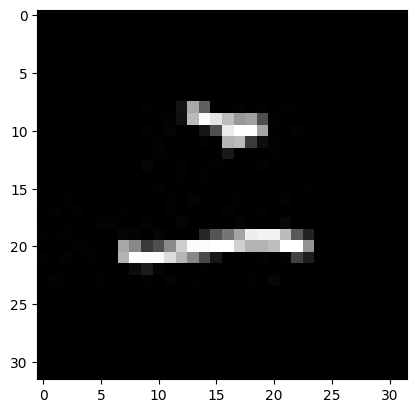

In [42]:
class MNIST_CH_Dataset(torch.utils.data.Dataset):
    def __init__(self,img_dir,images,transforms=None):
        self.img_dir = img_dir
        self.inputs = images
        self.transforms = transforms
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.inputs[idx])
        input = torchvision.io.read_image(img_path)
        if self.transforms:
            input = self.transforms(input)
        # input = torch.flatten(input)
        input = input.view(-1, 32)
        # input = input[:,None,:]
        target =torch.tensor(int(self.inputs[idx].split('.')[-2][-1] ))
        return input,target
    
transform_train = transforms.Compose([
                                    #   transforms.RandomRotation(45),
                                      transforms.RandomCrop(32),
                                      # transforms.RandomHorizontalFlip(p=0.5),
                                    #   transforms.RandomAffine(0, translate=(0.1, 0.1)),
                                      transforms.ConvertImageDtype(dtype=torch.float32),
                                      ])

train_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=train_images, transforms=transform_train )
test_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=test_images, transforms=transform_train )


train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=10, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=10, shuffle=False)


testInput,target = train_dataset.__getitem__(1)
print(testInput.shape,target)
plt.imshow(testInput,cmap='gray')

In [43]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor):
        
        hidden = torch.zeros(input_tensor.size(0), self.hidden_size)
        
        # Loop through each time step
        for t in range(input_tensor.size(1)):
            row = input_tensor[:, t, :]  # input at time step t
            combined = torch.cat((row, hidden), dim=1)  # concatenate input and hidden state
            h_t = torch.tanh(self.i2h(combined))  # update hidden state
        

        output = self.h2o(h_t)
        return output

In [44]:

input_size = 32
hidden_size = 128
output_size = 10
num_layers = 10
model = RNN(input_size,hidden_size,output_size)

# criterion = nn.NLLLoss()
learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [45]:
num_epochs = 100
train_losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss = []
    for i, (input,target) in enumerate(train_dataloader):
        # print(input.shape)
        input = input.reshape(-1, 32, 32)
        outputs = model(input)
        loss = criterion(outputs, target)
     
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if (i+1) % 10 == 0:
            # print(input.shape)
            # print(target.shape)
            # print(outputs.shape)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss

Epoch [1/100], Loss: 2.2978
Epoch [2/100], Loss: 2.3370
Epoch [3/100], Loss: 2.2885
Epoch [4/100], Loss: 2.2912
Epoch [5/100], Loss: 2.2950
Epoch [6/100], Loss: 2.3035
Epoch [7/100], Loss: 2.2986
Epoch [8/100], Loss: 2.3021
Epoch [9/100], Loss: 2.3080
Epoch [10/100], Loss: 2.2885
Epoch [11/100], Loss: 2.3065
Epoch [12/100], Loss: 2.2853
Epoch [13/100], Loss: 2.2887
Epoch [14/100], Loss: 2.3045
Epoch [15/100], Loss: 2.2818
Epoch [16/100], Loss: 2.2633
Epoch [17/100], Loss: 2.2901
Epoch [18/100], Loss: 2.3371
Epoch [19/100], Loss: 2.3268
Epoch [20/100], Loss: 2.3147
Epoch [21/100], Loss: 2.2738
Epoch [22/100], Loss: 2.2565
Epoch [23/100], Loss: 2.2566
Epoch [24/100], Loss: 2.3558
Epoch [25/100], Loss: 2.3267
Epoch [26/100], Loss: 2.2750
Epoch [27/100], Loss: 2.3334
Epoch [28/100], Loss: 2.2974
Epoch [29/100], Loss: 2.2646
Epoch [30/100], Loss: 2.2941
Epoch [31/100], Loss: 2.2541
Epoch [32/100], Loss: 2.3111
Epoch [33/100], Loss: 2.2896
Epoch [34/100], Loss: 2.2474
Epoch [35/100], Loss: 2

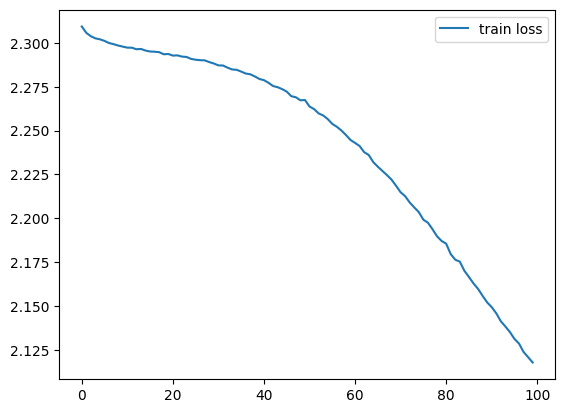

In [46]:
plt.plot(train_losses, label='train loss')
plt.legend()
plt.show()

In [47]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.reshape(-1, 32, 32)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 10.00%


tensor([[-0.0737,  0.3195,  0.0983,  0.2111, -0.1236, -0.2929, -0.1554,  0.0223,
          0.3031, -0.3243]], grad_fn=<AddmmBackward0>)
Result: 1


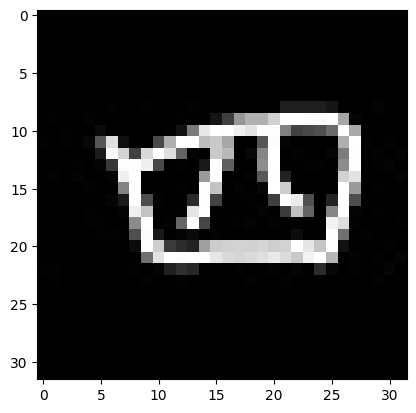

In [48]:

def get_result(img_path,model,transform):
    inputTensor = torchvision.io.read_image(img_path)
    inputTensor = transform(inputTensor)
    inputTensor = inputTensor.view(-1, 32)
    inputTensor = inputTensor[None,:]
    # print(inputTensor.shape)
    output = model(inputTensor)
    print(output)
    _, predictions = torch.max(output, 1)
    result = predictions.item()
    return result
#  example 
index = random.randrange(len(test_images))
test_image_path = os.path.join(os.getcwd()+"/MNIST-CH", test_images[index])

result = get_result(test_image_path,model,transform_train)

print(f"Result: {result}")
plt.imshow(torchvision.io.read_image(test_image_path)[0],cmap='gray')
